In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import AffinityPropagation, AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import requests
import folium
from folium.features import DivIcon
from folium import plugins
import altair as alt
import cenpy as cen
import contextily as ctx
import mapclassify
import geopandas as gpd
import geoviews as gv
import geoviews.feature as gf
import xarray as xr
from cartopy import crs
from holoviews.plotting.util import process_cmap
import esda
import libpysal as lps
from libpysal.weights import Queen, Rook, KNN, Kernel, DistanceBand
from splot.libpysal import plot_spatial_weights
import hvplot.pandas
from splot.esda import plot_local_autocorrelation
from OSMPythonTools.nominatim import Nominatim
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from branca.element import Figure, Template, MacroElement

In [3]:
nominatim = Nominatim()
overpass = Overpass()

In [ ]:
# pip install 

## Introduction

### GEOID
What is the Geographic Identifiers (GEOIDs), also called FIPS code?

- https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html

![fips code](https://customer.precisely.com/servlet/rtaImage?eid=ka06g000001hQNJ&feoid=00N6g00000TynF6&refid=0EM6g0000010wuS)

[Source: Precisely](https://customer.precisely.com/s/article/US-Census-definitions-of-a-Geography-and-FIPS-CODES?language=en_US)

![fips code](https://learn.arcgis.com/en/related-concepts/GUID-D7AA4FD1-E7FE-49D7-9D11-07915C9ACC68-web.png)

[Source: ESRI](https://learn.arcgis.com/en/related-concepts/united-states-census-geography.htm)

### The American Community Survey (ACS)

- Choice product for this project as it offers the best balance of timeliness and geographic specificity.
- It is conducted continuously and data is released annually in two forms:
    - 1-year release; only available for geographies with a population of 65,000 or more
    - 5-year release, which is available for almost all Census geographies, block group and larger
- In addition to data on age, sex, race and housing, the ACS includes data about education, income, occupation, veteran status, ancestry, and other topics.

[Source: Census Reporter](https://censusreporter.org/topics/about-census/)

### Region of interest

**St. Louis**

St. Louis is a major city in Missouri, located the Mississippi River with 104 cunsus tracts

*Fun Fact - Its iconic, 630-ft. Gateway Arch, built in the 1960s, honors the early 19th-century explorations of Lewis and Clark and America's westward expansion in general.*

In [4]:
# request St Louis data from OSM

base_url =  "https://nominatim.openstreetmap.org/search?format=json"
postcode = "63108"


response = requests.get(f"{base_url}&postalcode={postcode}&country=United States")
data = response.json()
data

[{'place_id': 302177326,
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
  'boundingbox': ['38.486370809475',
   '38.806370809475',
   '-90.415105075647',
   '-90.095105075647'],
  'lat': '38.64637080947489',
  'lon': '-90.25510507564688',
  'display_name': 'Saint Louis, Missouri, 63108, United States',
  'class': 'place',
  'type': 'postcode',
  'importance': 0.535}]

In [7]:
print(f"{base_url}&postalcode={postcode}&country=United States")

https://nominatim.openstreetmap.org/search?format=json&postalcode=63108&country=United States


In [ ]:
# St Louis latitude and longitude

latitude = data[0].get("lat")
longitude = data[0].get("lon")

latitude, longitude

('38.64637086326608', '-90.25510266733917')

In [ ]:
# map of St Louis

fig_slmap = Figure(height=600,width=1000)

location = float(latitude), float(longitude)

stlouis_map = folium.Map(location=location, zoom_start=12)

folium.Marker(location, popup="St. Louis").add_to(stlouis_map)

fig_slmap.add_child(stlouis_map)

stlouis_map

## Importing data using OSMPythonTools

In [4]:
# include the location lookup

city = nominatim.query("St Louis, United States")
city.areaId()

3601180533

In [9]:
# prepare query
school_query = overpassQueryBuilder(
    area=city.areaId(),
    elementType='node',                     # which are points (OSM also has ways and relations)
    selector='"amenity"="school"',          # tag required
    out='body',                             # body indicates that we want the data, not just the count
    includeGeometry=True                    # and we want the geometric information, too
)

# execute query
school_data = overpass.query(school_query, timeout=60)

NameError: name 'overpassQueryBuilder' is not defined

In [ ]:
print("Number of nodes found: {}".format(school_data.countElements()))

Number of nodes found: 44


In [ ]:
school_data.nodes()[3].tags()

{'amenity': 'school',
 'ele': '151',
 'gnis:county_id': '510',
 'gnis:created': '10/24/1980',
 'gnis:feature_id': '765710',
 'gnis:state_id': '29',
 'name': 'Longfellow School'}

In [ ]:
# get ids and coordinates of schools
school_loc = [(item.id(), item.geometry()) for item in school_data.nodes()]

# create GeoDataFrame
schools = gpd.GeoDataFrame(school_loc, columns=["id", "geometry"])

schools.head()

,id,geometry
0,358083413,POINT (-90.22650 38.62089)
1,358083417,POINT (-90.24289 38.57755)
2,358083525,POINT (-90.31267 38.59625)
3,358083529,POINT (-90.30456 38.60727)
4,358083532,POINT (-90.23567 38.61700)


In [ ]:
schools.shape

(44, 2)

## Importing OSM data extracted through QGIS

In [5]:
osm_dict = {
    "sl_edu": "data/GeoJSON/osm education.geojson",
    "sl_commland": "data/GeoJSON/osm commercial landuse.geojson",
    "sl_healthcare_point": "data/GeoJSON/osm healthcare point.geojson",
    "sl_healthcare_polygon": "data/GeoJSON/osm healthcare polygon.geojson",
    "sl_highway": "data/GeoJSON/osm highway.geojson",
    "sl_prison_graveyard": "data/GeoJSON/osm prison graveyard.geojson"
}

osm_dict_list = list(osm_dict.keys())

In [6]:
a = np.zeros((2, 3))
b = []

for i, j in np.argwhere(a == 0):
    b.append([i, j])

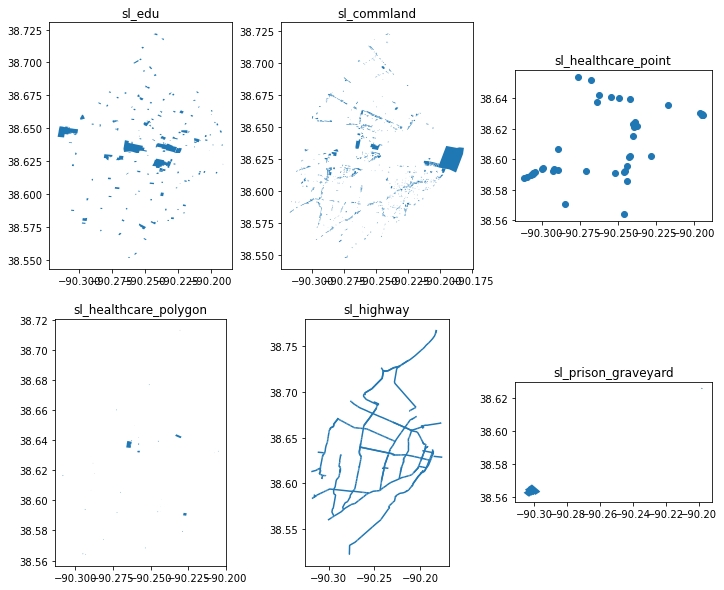

In [7]:
# plot all geodataframe to show distribution

y = 0
sl_column_dict = {}
fig, axs = plt.subplots(figsize=(12,10), ncols=3, nrows=2)

for l, v in osm_dict.items():
    k = gpd.read_file(v)
    k.plot(ax=axs[b[y][0]][b[y][1]])
    axs[b[y][0], b[y][1]].set_title(osm_dict_list[y])
    sl_column_dict[osm_dict_list[y]] = k.columns
    vars()[l] = k.copy()
    y+=1

In [8]:
# column within each geodataframe

sl_column_dict.get("sl_prison_graveyard")

Index(['full_id', 'osm_id', 'osm_type', 'amenity', 'website', 'phone',
       'building_l', 'building', 'addr_stree', 'addr_state', 'addr_postc',
       'addr_house', 'addr_city', 'name', 'landuse', 'gnis_state',
       'gnis_featu', 'gnis_creat', 'gnis_count', 'ele', 'geometry'],
      dtype='object')

## Trial importing census data with cenpy

In [11]:
# census data available through cenpy

explore = cen.explorer.available()
explore.columns

Index(['c_isTimeseries', 'c_isMicrodata', 'publisher', 'temporal', 'spatial',
       'programCode', 'modified', 'keyword', 'contactPoint', 'distribution',
       'description', 'bureauCode', 'accessLevel', 'title', 'c_isAvailable',
       'c_isCube', 'c_isAggregate', 'c_dataset', 'vintage'],
      dtype='object')

In [12]:
acs_data = [i for i in explore.index if "ACS" in i]

In [13]:
# sort by year, showing only row index with "ACS" within it

explore_sort = explore[explore.index.isin(acs_data)][["description", "vintage"]].sort_values("vintage", ascending=False)

explore_sort.to_excel("data/explore.xlsx")

In [14]:
explore_sort.head()

,description,vintage
ACSST1Y2021,The American Community Survey (ACS) is a US-wi...,2021.0
ACSDT1Y2021,The American Community Survey (ACS) is an ongo...,2021.0
ACSDP1Y2021,The American Community Survey (ACS) is a US-wi...,2021.0
ACSCP1Y2021,The American Community Survey (ACS) is an ongo...,2021.0
ACSSPP1Y2021,Selected Population Profiles provide broad soc...,2021.0


In [15]:
# top row description

explore_sort.iloc[0][0]

"The American Community Survey (ACS) is a US-wide survey designed to provide communities a fresh look at how they are changing. The ACS replaced the decennial census long form in 2010 and thereafter by collecting long form type information throughout the decade rather than only once every 10 years. Questionnaires are mailed to a sample of addresses to obtain information about households -- that is, about each person and the housing unit itself. The American Community Survey produces demographic, social, housing and economic estimates in the form of 1 and 5-year estimates based on population thresholds. The strength of the ACS is in estimating population and housing characteristics. The data profiles provide key estimates for each of the topic areas covered by the ACS for the us, all 50 states, the District of Columbia, Puerto Rico, every congressional district, every metropolitan area, and all counties and places with populations of 65,000 or more. Although the ACS produces population,

In [ ]:
# investigate variables
# apikey=???
# DECENNIALSF12010 working....why??

# cxn = cen.remote.APIConnection('ACSST5Y2020')
# explore_var = cxn.variables
# explore_var.columns

In [ ]:
# acs = cen.products.ACS()

In [ ]:
# vars_dict = {
#     "B25077_001E": "median_house_value",  # Median house value
#     "B02001_002E": "total_pop_white",     # Total white population
#     "B01003_001E": "total_pop",           # Total population
#     "B25003_003E": "total_rented",        # Total rented occupied
#     "B25001_001E": "total_housing_units", # Total housing units
#     "B09019_006E": "hh_female",           # Female households
#     "B09019_001E": "hh_total",            # Total households
#     "B15003_002E": "total_bachelor",      # Total w/ Bachelor degree
#     "B25018_001E": "median_no_rooms",     # Median number of rooms
#     "B19083_001E": "income_gini",         # Gini index of income inequality
#     "B01002_001E": "median_age",          # Median age
#     "B08303_001E": "tt_work",             # Aggregate travel time to work
#     "B19013_001E": "median_hh_income"     # Median household income
# }
# vars_list = list(vars_dict.keys())

In [ ]:
# vars_list

In [ ]:
# db = acs.from_place("St Louis, MO",
#                   level="tract",
#                   variables=vars_list
#                  )

## Importing data gotten from census reporter

### St Louis Populaion of age at least 15 years enrolled in college or graduate school

In [ ]:
enrollment0 = gpd.read_file("data/GeoJSON/census sex by enrollment by age.geojson")
enrollment0.shape

(419, 69)

In [ ]:
enrollment0.sample()

,geoid,name,B14004001,"B14004001, Error",B14004002,"B14004002, Error",B14004003,"B14004003, Error",B14004004,"B14004004, Error",...,"B14004029, Error",B14004030,"B14004030, Error",B14004031,"B14004031, Error",B14004032,"B14004032, Error",B14004033,"B14004033, Error",geometry
89,14000US29510125600,"Census Tract 1256, St. Louis, MO",5090.0,707.0,3198.0,594.0,142.0,100.0,0.0,17.0,...,346.0,51.0,71.0,204.0,148.0,676.0,266.0,757.0,191.0,"MULTIPOLYGON (((-90.20004 38.62302, -90.19968 ..."


<AxesSubplot:>

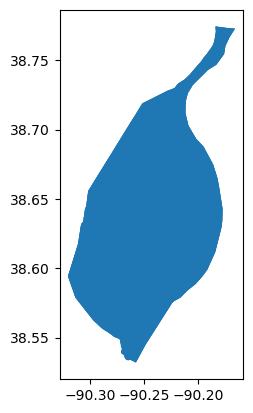

In [ ]:
enrollment0.plot()

<AxesSubplot:>

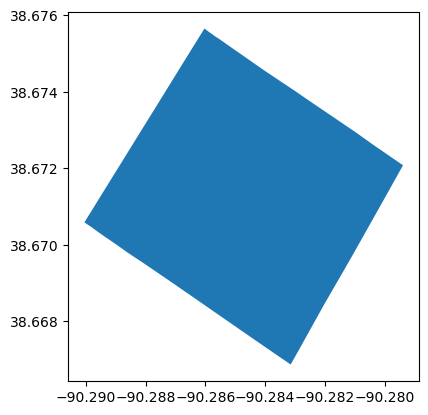

In [ ]:
enrollment0.sample().plot()

In [ ]:
enrollment0.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 419 entries, 0 to 418
Data columns (total 69 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   geoid             419 non-null    object  
 1   name              419 non-null    object  
 2   B14004001         105 non-null    float64 
 3   B14004001, Error  105 non-null    float64 
 4   B14004002         105 non-null    float64 
 5   B14004002, Error  105 non-null    float64 
 6   B14004003         105 non-null    float64 
 7   B14004003, Error  105 non-null    float64 
 8   B14004004         105 non-null    float64 
 9   B14004004, Error  105 non-null    float64 
 10  B14004005         105 non-null    float64 
 11  B14004005, Error  105 non-null    float64 
 12  B14004006         105 non-null    float64 
 13  B14004006, Error  105 non-null    float64 
 14  B14004007         105 non-null    float64 
 15  B14004007, Error  105 non-null    float64 
 16  B14004008         

In [ ]:
# list of columns to keep

col_keep_e = ['geoid',
 'name',
 'B14004001',
 'B14004002',
 'B14004003',
 'B14004004',
 'B14004005',
 'B14004006',
 'B14004007',
 'B14004008',
 'B14004009',
 'B14004010',
 'B14004011',
 'B14004012',
 'B14004013',
 'B14004018',
 'B14004019',
 'B14004020',
 'B14004021',
 'B14004022',
 'B14004023',
 'B14004024',
 'B14004025',
 'B14004026',
 'B14004027',
 'B14004028',
 'B14004029',
 'geometry']

col_rename_e = ['geoid',
 'name',
 'sl_total_15_over',
 'sl_male_15_over',
 'public_m',
 'mpu_15_17',
 'mpu_18_24',
 'mpu_25_34',
 'mpu_35_over',
 'private_m',
 'mpr_15_17',
 'mpr_18_24',
 'mpr_25_34',
 'mpr_35_over',
 'not_enrolled_m',
 'sl_female_15_over',
 'public_f',
 'fpu_15_17',
 'fpu_18_24',
 'fpu_25_34',
 'fpu_35_over',
 'private_f',
 'fpr_15_17',
 'fpr_18_24',
 'fpr_25_34',
 'fpr_35_over',
 'not_enrolled_f',
 'geometry']

In [ ]:
enrollment1 = enrollment0[col_keep_e]
enrollment1.columns = col_rename_e

In [ ]:
enrollment1.head(1)

,geoid,name,sl_total_15_over,sl_male_15_over,public_m,mpu_15_17,mpu_18_24,mpu_25_34,mpu_35_over,private_m,...,fpu_18_24,fpu_25_34,fpu_35_over,private_f,fpr_15_17,fpr_18_24,fpr_25_34,fpr_35_over,not_enrolled_f,geometry
0,14000US29510101100,"Census Tract 1011, St. Louis, MO",2103.0,998.0,24.0,0.0,18.0,6.0,0.0,8.0,...,7.0,0.0,17.0,15.0,0.0,9.0,6.0,0.0,1066.0,"MULTIPOLYGON (((-90.28695 38.55552, -90.28692 ..."


In [ ]:
list(enrollment1.name.head()) + list(enrollment1.name.tail())

# Data contain rows summarizing for each census tract and for the entire city

['Census Tract 1011, St. Louis, MO',
 'Census Tract 1012, St. Louis, MO',
 'Census Tract 1013, St. Louis, MO',
 'Census Tract 1014, St. Louis, MO',
 'Census Tract 1015, St. Louis, MO',
 'BG 2, Tract 1277, St. Louis, MO',
 'BG 3, Tract 1277, St. Louis, MO',
 'BG 1, Tract 1278, St. Louis, MO',
 'BG 2, Tract 1278, St. Louis, MO',
 'St. Louis, MO']

In [ ]:
# extract only information per block group in St Louis

enrollment2 = enrollment1.loc[enrollment1.name.str.startswith("BG")]

enrollment2.sample()

,geoid,name,sl_total_15_over,sl_male_15_over,public_m,mpu_15_17,mpu_18_24,mpu_25_34,mpu_35_over,private_m,...,fpu_18_24,fpu_25_34,fpu_35_over,private_f,fpr_15_17,fpr_18_24,fpr_25_34,fpr_35_over,not_enrolled_f,geometry
285,15000US295101154001,"BG 1, Tract 1154, St. Louis, MO",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-90.26353 38.57686, -90.26309 ..."


In [ ]:
# It is noted the no information exists at the block group level, so datta is reverted to the census tract level

enrollment3 = enrollment1.loc[enrollment1.name.str.startswith("Census")]

enrollment3.sample()

,geoid,name,sl_total_15_over,sl_male_15_over,public_m,mpu_15_17,mpu_18_24,mpu_25_34,mpu_35_over,private_m,...,fpu_18_24,fpu_25_34,fpu_35_over,private_f,fpr_15_17,fpr_18_24,fpr_25_34,fpr_35_over,not_enrolled_f,geometry
2,14000US29510101300,"Census Tract 1013, St. Louis, MO",3174.0,1403.0,0.0,0.0,0.0,0.0,0.0,45.0,...,38.0,33.0,16.0,20.0,0.0,0.0,0.0,20.0,1664.0,"MULTIPOLYGON (((-90.27362 38.56990, -90.27331 ..."


In [ ]:
enrollment3.shape

(104, 28)

### Occupancy status

In [ ]:
occupancy0 = gpd.read_file("data/GeoJSON/census occupancy status.geojson")
occupancy0.shape

(105, 9)

In [ ]:
occupancy0.sample()

,geoid,name,B25002001,"B25002001, Error",B25002002,"B25002002, Error",B25002003,"B25002003, Error",geometry
87,14000US29510124600,"Census Tract 1246, St. Louis, MO",921.0,83.0,736.0,81.0,185.0,63.0,"MULTIPOLYGON (((-90.22765 38.58271, -90.22753 ..."


<AxesSubplot:>

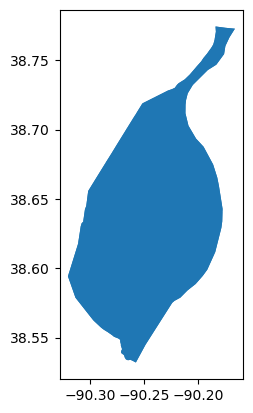

In [ ]:
occupancy0.plot()

In [ ]:
occupancy0.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   geoid             105 non-null    object  
 1   name              105 non-null    object  
 2   B25002001         105 non-null    float64 
 3   B25002001, Error  105 non-null    float64 
 4   B25002002         105 non-null    float64 
 5   B25002002, Error  105 non-null    float64 
 6   B25002003         105 non-null    float64 
 7   B25002003, Error  105 non-null    float64 
 8   geometry          105 non-null    geometry
dtypes: float64(6), geometry(1), object(2)
memory usage: 7.5+ KB


In [ ]:
# list of columns to keep

col_keep_o = ['geoid',
 'name',
 'B25002001',
 'B25002002',
 'B25002003',
 'geometry']

col_rename_o = ['geoid',
 'name',
 'housing_units',
 'occupied',
 'vacant',
 'geometry']

In [ ]:
occupancy1 = occupancy0[col_keep_o]
occupancy1.columns = col_rename_o

In [ ]:
occupancy1.tail(3)

,geoid,name,housing_units,occupied,vacant,geometry
102,14000US29510127700,"Census Tract 1277, St. Louis, MO",1411.0,832.0,579.0,"MULTIPOLYGON (((-90.23843 38.65102, -90.23821 ..."
103,14000US29510127800,"Census Tract 1278, St. Louis, MO",1771.0,1492.0,279.0,"MULTIPOLYGON (((-90.23665 38.62618, -90.23655 ..."
104,16000US2965000,"St. Louis, MO",176955.0,143566.0,33389.0,"MULTIPOLYGON (((-90.32052 38.59415, -90.32050 ..."


In [ ]:
uuu = occupancy1.tail(1)

In [ ]:
uuu

,geoid,name,housing_units,occupied,vacant,geometry
104,16000US2965000,"St. Louis, MO",176955.0,143566.0,33389.0,"MULTIPOLYGON (((-90.32052 38.59415, -90.32050 ..."


In [ ]:
uuu = uuu.to_crs(epsg=2263)

# Access the centroid attribute of each polygon
uuu['centroid'] = uuu.centroid

In [ ]:
uuu = uuu.to_crs(epsg=4326)

# Centroid column
uuu['centroid'] = uuu['centroid'].to_crs(epsg=4326)

In [ ]:
uuu

,geoid,name,housing_units,occupied,vacant,geometry,centroid
104,16000US2965000,"St. Louis, MO",176955.0,143566.0,33389.0,"MULTIPOLYGON (((-90.32052 38.59415, -90.32050 ...",POINT (-90.24512 38.63581)


In [ ]:
# delete row with sum of each attributes for all census tract

occupancy2 = occupancy1.drop(occupancy1.tail(1).index)

occupancy2.shape

(104, 6)

### merge census data

In [ ]:
census_data = enrollment3.drop(columns="geometry", axis=1).merge(occupancy2.drop(columns="name", axis=1), on="geoid")

In [ ]:
census_data.sample()

,geoid,name,sl_total_15_over,sl_male_15_over,public_m,mpu_15_17,mpu_18_24,mpu_25_34,mpu_35_over,private_m,...,private_f,fpr_15_17,fpr_18_24,fpr_25_34,fpr_35_over,not_enrolled_f,housing_units,occupied,vacant,geometry
73,14000US29510118100,"Census Tract 1181, St. Louis, MO",942.0,521.0,8.0,0.0,0.0,8.0,0.0,7.0,...,19.0,0.0,4.0,15.0,0.0,391.0,774.0,593.0,181.0,"MULTIPOLYGON (((-90.26601 38.62065, -90.26594 ..."


### check data integrity

In [ ]:
census_data.isnull().sum()

geoid                0
name                 0
sl_total_15_over     0
sl_male_15_over      0
public_m             0
mpu_15_17            0
mpu_18_24            0
mpu_25_34            0
mpu_35_over          0
private_m            0
mpr_15_17            0
mpr_18_24            0
mpr_25_34            0
mpr_35_over          0
not_enrolled_m       0
sl_female_15_over    0
public_f             0
fpu_15_17            0
fpu_18_24            0
fpu_25_34            0
fpu_35_over          0
private_f            0
fpr_15_17            0
fpr_18_24            0
fpr_25_34            0
fpr_35_over          0
not_enrolled_f       0
housing_units        0
occupied             0
vacant               0
geometry             0
dtype: int64

In [ ]:
# pick a row

random_block = census_data.sample()
random_block

,geoid,name,sl_total_15_over,sl_male_15_over,public_m,mpu_15_17,mpu_18_24,mpu_25_34,mpu_35_over,private_m,...,private_f,fpr_15_17,fpr_18_24,fpr_25_34,fpr_35_over,not_enrolled_f,housing_units,occupied,vacant,geometry
39,14000US29510109700,"Census Tract 1097, St. Louis, MO",1532.0,791.0,23.0,0.0,14.0,0.0,9.0,29.0,...,9.0,0.0,0.0,9.0,0.0,713.0,1478.0,816.0,662.0,"MULTIPOLYGON (((-90.21964 38.67156, -90.21848 ..."


In [ ]:
print('Total population: ' + str(random_block.iloc[0]['sl_total_15_over']))
print('Male + Female: ' + str(random_block.iloc[0]['sl_male_15_over'] + random_block.iloc[0]['sl_female_15_over']))

Total population: 1532.0
Male + Female: 1532.0


In [ ]:
print('Male population: ' + str(random_block.iloc[0]['sl_male_15_over']))
print('Male population confirmed by enrollment: ' + str(random_block.iloc[0]['public_m']
    + random_block.iloc[0]['private_m'] + random_block.iloc[0]['not_enrolled_m']))
print('Male population confirmed by age: ' + str(random_block.iloc[0]['mpu_15_17'] + random_block.iloc[0]['mpu_18_24']
    + random_block.iloc[0]['mpu_25_34'] + random_block.iloc[0]['mpu_35_over']
    + random_block.iloc[0]['mpr_15_17'] + random_block.iloc[0]['mpr_18_24']
    + random_block.iloc[0]['mpr_25_34'] + random_block.iloc[0]['mpr_35_over']
    + random_block.iloc[0]['not_enrolled_m']))

Male population: 791.0
Male population confirmed by enrollment: 791.0
Male population confirmed by age: 791.0


In [ ]:
print('Female population: ' + str(random_block.iloc[0]['sl_female_15_over']))
print('Female population confirmed by enrollment: ' + str(random_block.iloc[0]['public_f']
    + random_block.iloc[0]['private_f'] + random_block.iloc[0]['not_enrolled_f']))
print('Female population confirmed by age: ' + str(random_block.iloc[0]['fpu_15_17'] + random_block.iloc[0]['fpu_18_24']
    + random_block.iloc[0]['fpu_25_34'] + random_block.iloc[0]['fpu_35_over']
    + random_block.iloc[0]['fpr_15_17'] + random_block.iloc[0]['fpr_18_24']
    + random_block.iloc[0]['fpr_25_34'] + random_block.iloc[0]['fpr_35_over']
    + random_block.iloc[0]['not_enrolled_f']))

Female population: 741.0
Female population confirmed by enrollment: 741.0
Female population confirmed by age: 741.0


In [ ]:
print('Total housing units: ' + str(random_block.iloc[0]['housing_units']))
print('Occupied + vacant: ' + str(random_block.iloc[0]['occupied'] + random_block.iloc[0]['vacant']))

Total housing units: 1478.0
Occupied + vacant: 1478.0


## Spatial join

In [ ]:
osm_dict_list

['sl_edu',
 'sl_commland',
 'sl_healthcare_point',
 'sl_healthcare_polygon',
 'sl_highway',
 'sl_prison_graveyard']

In [ ]:
osm_dict_list_new = [i+"_trim" for i in osm_dict_list]

osm_columns_keep = ['full_id', 'osm_id', 'osm_type', 'geometry']

In [ ]:
r = 0
compare_shape = []

for k in osm_dict_list_new:
    u = osm_dict_list[r]
    j = gpd.sjoin(vars()[u][osm_columns_keep], census_data)
    compare_shape.append(j.shape)
    m = j[['geoid', 'index_right']].groupby('geoid').agg('count').rename(columns={"index_right": u})
    vars()[k] = m.copy()
    r+=1

In [ ]:
compare_shape

[(151, 35), (1038, 35), (42, 35), (31, 35), (871, 35), (2, 35)]

## Merge count of attribute

In [ ]:
merged_data0 = census_data.copy()

In [ ]:
for i in osm_dict_list_new:
    merged_data0 = merged_data0.merge(vars()[i], on='geoid', how='outer').fillna(0)

In [ ]:
census_data.shape, merged_data0.shape

((104, 31), (104, 37))

In [ ]:
merged_data0["sl_healthcare"] = merged_data0.sl_healthcare_point + merged_data0.sl_healthcare_polygon
merged_data0["sl_students_enrolled"] = merged_data0.public_m + merged_data0.private_m + merged_data0.public_f + merged_data0.private_f
merged_data0["sl_students_not_enrolled"] = merged_data0.not_enrolled_m + merged_data0.not_enrolled_f

In [ ]:
merged_data0.columns

Index(['geoid', 'name', 'sl_total_15_over', 'sl_male_15_over', 'public_m',
       'mpu_15_17', 'mpu_18_24', 'mpu_25_34', 'mpu_35_over', 'private_m',
       'mpr_15_17', 'mpr_18_24', 'mpr_25_34', 'mpr_35_over', 'not_enrolled_m',
       'sl_female_15_over', 'public_f', 'fpu_15_17', 'fpu_18_24', 'fpu_25_34',
       'fpu_35_over', 'private_f', 'fpr_15_17', 'fpr_18_24', 'fpr_25_34',
       'fpr_35_over', 'not_enrolled_f', 'housing_units', 'occupied', 'vacant',
       'geometry', 'sl_edu', 'sl_commland', 'sl_healthcare_point',
       'sl_healthcare_polygon', 'sl_highway', 'sl_prison_graveyard',
       'sl_healthcare', 'sl_students_enrolled', 'sl_students_not_enrolled'],
      dtype='object')

In [ ]:
merged_data1 = merged_data0.drop(columns=['public_m',
       'mpu_15_17', 'mpu_18_24', 'mpu_25_34', 'mpu_35_over', 'private_m',
       'mpr_15_17', 'mpr_18_24', 'mpr_25_34', 'mpr_35_over', 'not_enrolled_m',
       'public_f', 'fpu_15_17', 'fpu_18_24', 'fpu_25_34',
       'fpu_35_over', 'private_f', 'fpr_15_17', 'fpr_18_24', 'fpr_25_34',
       'fpr_35_over', 'not_enrolled_f', 'sl_healthcare_point',
       'sl_healthcare_polygon'])

In [ ]:
merged_data1.sample()

,geoid,name,sl_total_15_over,sl_male_15_over,sl_female_15_over,housing_units,occupied,vacant,geometry,sl_edu,sl_commland,sl_highway,sl_prison_graveyard,sl_healthcare,sl_students_enrolled,sl_students_not_enrolled
44,14000US29510110500,"Census Tract 1105, St. Louis, MO",794.0,336.0,458.0,804.0,429.0,375.0,"MULTIPOLYGON (((-90.22860 38.66678, -90.22832 ...",1.0,1.0,9.0,0.0,0.0,27.0,767.0


In [ ]:
type(merged_data1)

geopandas.geodataframe.GeoDataFrame

## Geovisualization

In [ ]:
describe = merged_data1.copy()

In [ ]:
describe.describe().T

,count,mean,std,min,25%,50%,75%,max
sl_total_15_over,104.0,2451.173077,1035.913915,743.0,1669.75,2271.0,3238.75,5090.0
sl_male_15_over,104.0,1174.326923,555.664082,309.0,698.25,1130.0,1520.50,3198.0
sl_female_15_over,104.0,1276.846154,534.782794,338.0,893.75,1204.5,1741.50,2878.0
housing_units,104.0,1701.490385,646.328976,587.0,1145.25,1627.0,2103.50,3810.0
occupied,104.0,1380.442308,631.948717,350.0,913.50,1292.5,1824.00,3391.0
vacant,104.0,321.048077,182.568321,0.0,180.00,289.0,419.25,895.0
sl_edu,104.0,1.451923,1.350151,0.0,0.75,1.0,2.00,6.0
sl_commland,104.0,9.980769,10.071570,0.0,2.00,7.0,16.00,44.0
sl_highway,104.0,8.375000,8.523169,0.0,2.00,6.0,11.25,42.0
sl_prison_graveyard,104.0,0.019231,0.138000,0.0,0.00,0.0,0.00,1.0


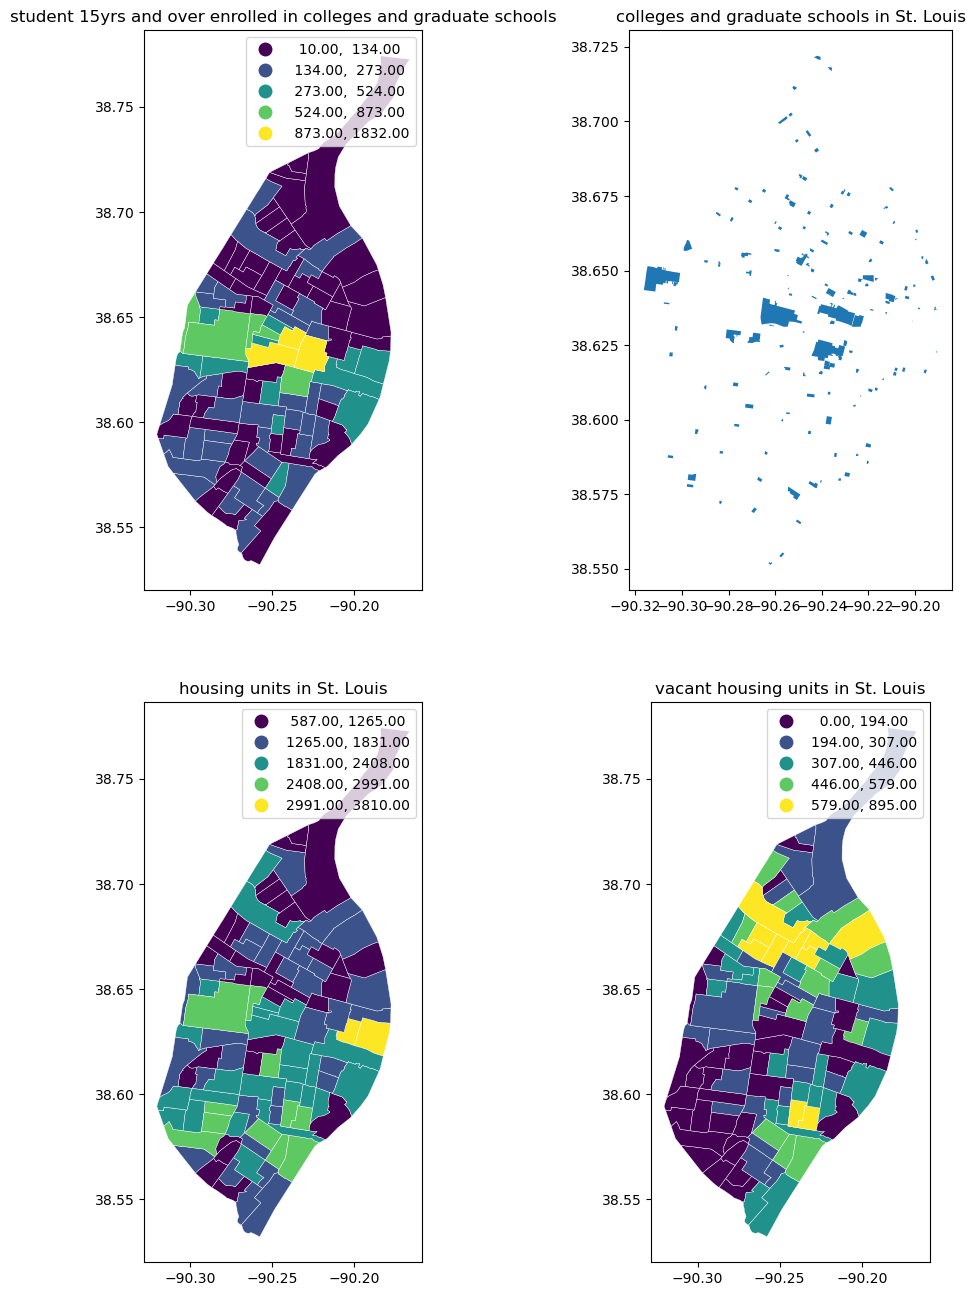

In [ ]:
f, ax = plt.subplots(figsize=(12,16), ncols=2, nrows=2)
describe.plot(column='sl_students_enrolled', scheme='FisherJenks', ax=ax[0][0],
        edgecolor='white', legend=True, linewidth=0.3)
ax[0][0].set_title("student 15yrs and over enrolled in colleges and graduate schools")
sl_edu.plot(ax=ax[0][1])
ax[0][1].set_title("colleges and graduate schools in St. Louis")
describe.plot(column='housing_units', scheme='FisherJenks', ax=ax[1][0],
        edgecolor='white', legend=True, linewidth=0.3)
ax[1][0].set_title("housing units in St. Louis")
describe.plot(column='vacant', scheme='FisherJenks', ax=ax[1][1],
        edgecolor='white', legend=True, linewidth=0.3)
ax[1][1].set_title("vacant housing units in St. Louis")
plt.show()

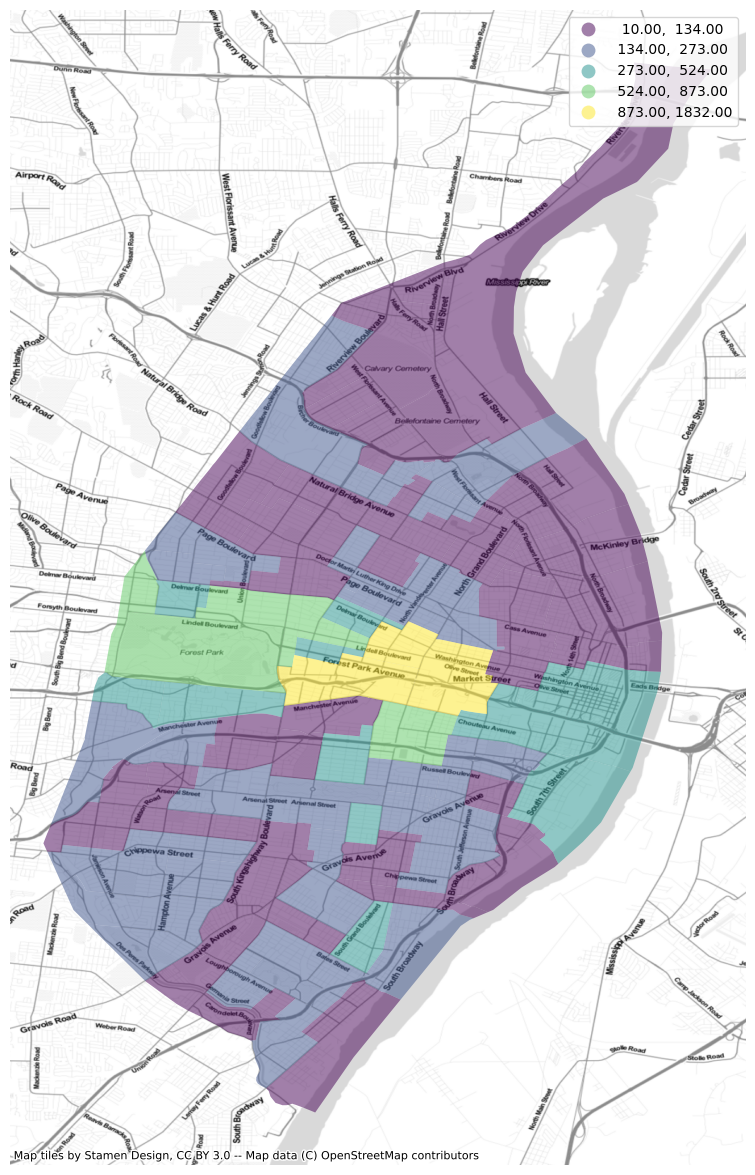

In [ ]:
f, ax = plt.subplots(figsize=(12,15))
describe.plot(column='sl_students_enrolled', scheme='FisherJenks', alpha=0.5, ax=ax, legend=True)
ctx.add_basemap(ax, crs=describe.crs.to_string(), source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()
plt.show()

<AxesSubplot:>

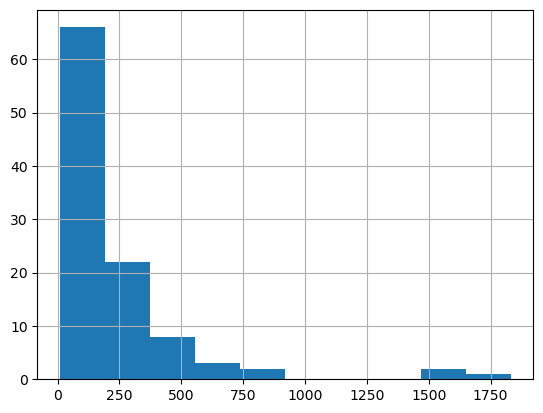

In [ ]:
describe.sl_students_enrolled.hist()

**spatial lag**

This is a measure of attribute similarity to pair up neighbors (i.e., geographically similar)

For neighborhood $i$, the spatial lag is defined as: $$ylag_i = \sum_j w_{i,j} y_j$$

The classifier map for the spatial lag tends to enhance the impression of value similarity in space. It is, in effect, a local smoother.

In [ ]:
# spatial weights with queen contiguity

wq =  lps.weights.Queen.from_dataframe(describe)
wq.transform = 'r'

In [ ]:
y = describe['sl_students_enrolled']
ylag = lps.weights.lag_spatial(wq, y)

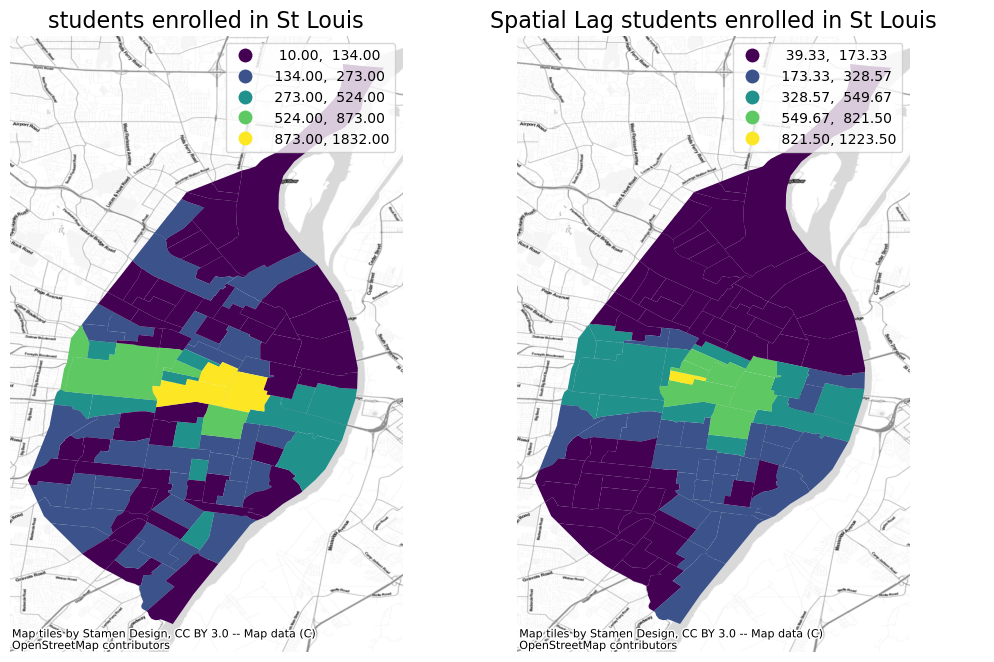

In [ ]:
describe['lag_enrolled_students'] = ylag

f,ax = plt.subplots(1,2,figsize=(12,8))

describe.plot(column='sl_students_enrolled', ax=ax[0],
        scheme="FisherJenks",  k=5, legend=True)

ax[0].set_title("students enrolled in St Louis", fontsize=16)

describe.plot(column='lag_enrolled_students', ax=ax[1],
        scheme='FisherJenks', k=5, legend=True)

ctx.add_basemap(ax[0], crs=describe.crs.to_string(), source=ctx.providers.Stamen.TonerLite)

ctx.add_basemap(ax[1], crs=describe.crs.to_string(), source=ctx.providers.Stamen.TonerLite)

ax[1].set_title("Spatial Lag students enrolled in St Louis", fontsize=16)
ax[0].axis('off')
ax[1].axis('off')

plt.show()

**Spatial Autocorrelation**

This relates to the combination of two types of similarity: spatial similarity and attribute similarity.

we plot below using a p-value threshold of 0.05

(<Figure size 1500x600 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <AxesSubplot:>, <AxesSubplot:>], dtype=object))

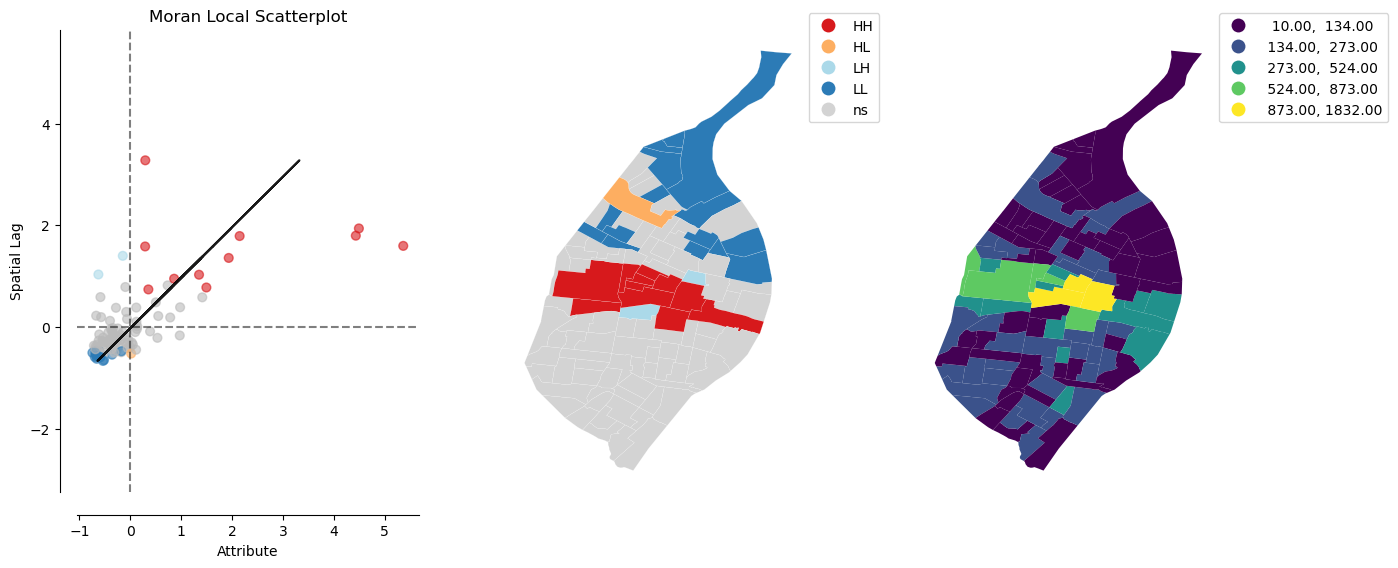

In [ ]:
li = esda.moran.Moran_Local(y, wq)

p_value = 0.05

plot_local_autocorrelation(li, describe, 'sl_students_enrolled', p=p_value, 
        scheme='FisherJenks', figsize=(15, 6), cmap="viridis")

## Geodemographic Clusters

[Geodemographic analysis](https://en.wikipedia.org/wiki/Geodemographic_segmentation) includes applying unsupervised learning to demographic and socioeconomic data, followed by a spatial analysis of the results

In [ ]:
cluster = merged_data1.copy()

In [ ]:
cluster.columns

Index(['geoid', 'name', 'sl_total_15_over', 'sl_male_15_over',
       'sl_female_15_over', 'housing_units', 'occupied', 'vacant', 'geometry',
       'sl_edu', 'sl_commland', 'sl_highway', 'sl_prison_graveyard',
       'sl_healthcare', 'sl_students_enrolled', 'sl_students_not_enrolled'],
      dtype='object')

In [ ]:
cluster_columns = ['sl_total_15_over', 'sl_male_15_over',
       'sl_female_15_over', 'housing_units', 'occupied', 'vacant',
       'sl_edu', 'sl_commland', 'sl_highway', 'sl_prison_graveyard',
       'sl_healthcare', 'sl_students_enrolled', 'sl_students_not_enrolled']

In [ ]:
scaler = StandardScaler()

sl_kmeans = KMeans(n_clusters=6).fit(scaler.fit_transform(cluster[cluster_columns]))

In [ ]:
cluster['kmeans'] = sl_kmeans.labels_

cluster.kmeans.unique()

array([2, 4, 1, 3, 0, 5])

In [ ]:
cluster.groupby('kmeans')[cluster_columns].mean().T

kmeans,0,1,2,3,4,5
sl_total_15_over,1379.166667,3689.076923,2464.529412,2371.368421,3693.0,3754.25
sl_male_15_over,614.750000,1748.538462,1167.411765,1202.000000,2159.5,1883.50
sl_female_15_over,764.416667,1940.538462,1297.117647,1169.368421,1533.5,1870.75
housing_units,1094.055556,2495.730769,1608.882353,1672.052632,2728.0,2026.00
occupied,752.750000,2138.115385,1295.823529,1422.736842,2443.5,1732.00
vacant,341.305556,357.615385,313.058824,249.315789,284.5,294.00
sl_edu,1.361111,1.230769,0.647059,2.052632,0.5,4.75
sl_commland,6.527778,15.192308,3.235294,16.210526,5.5,8.50
sl_highway,6.888889,7.884615,3.000000,11.631579,22.0,25.50
sl_prison_graveyard,0.000000,0.000000,0.000000,0.000000,1.0,0.00


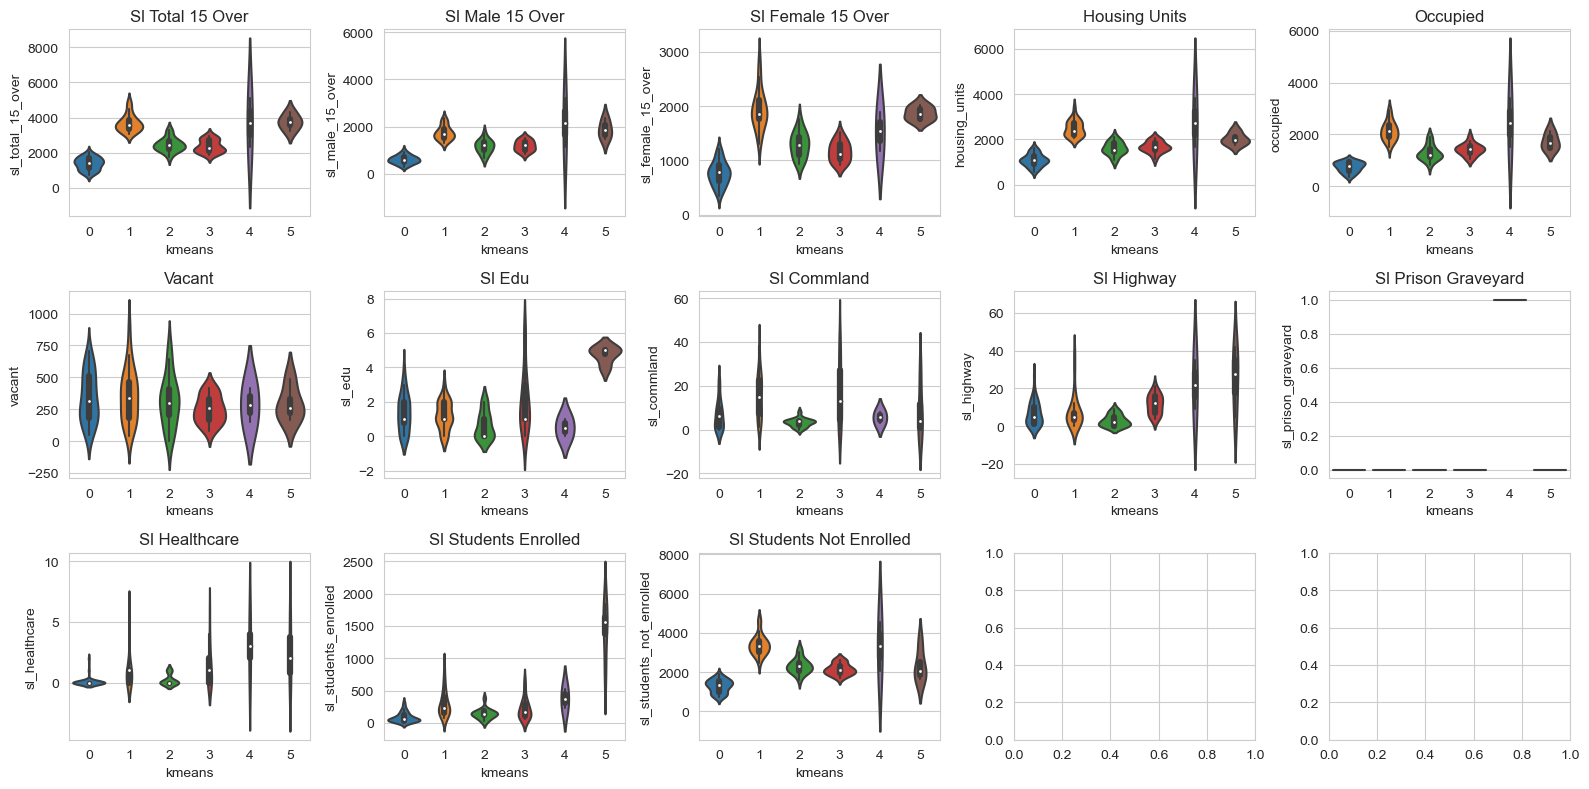

In [ ]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(3,5, figsize=(16,8))
ax=ax.flatten()
for i, col in enumerate(cluster_columns):
    sns.violinplot(data=cluster, y=col, x=cluster.kmeans, ax=ax[i])
    ax[i].set_title(col.replace("_", " ").title())
plt.tight_layout()

In [ ]:
cluster.sample()

,geoid,name,sl_total_15_over,sl_male_15_over,sl_female_15_over,housing_units,occupied,vacant,geometry,sl_edu,sl_commland,sl_highway,sl_prison_graveyard,sl_healthcare,sl_students_enrolled,sl_students_not_enrolled,kmeans
21,14000US29510105400,"Census Tract 1054, St. Louis, MO",1826.0,672.0,1154.0,1176.0,993.0,183.0,"MULTIPOLYGON (((-90.29688 38.66197, -90.29616 ...",0.0,2.0,10.0,0.0,0.0,164.0,1662.0,0


## Assign weights

In [ ]:
merged_data1.columns

Index(['geoid', 'name', 'sl_total_15_over', 'sl_male_15_over',
       'sl_female_15_over', 'housing_units', 'occupied', 'vacant', 'geometry',
       'sl_edu', 'sl_commland', 'sl_highway', 'sl_prison_graveyard',
       'sl_healthcare', 'sl_students_enrolled', 'sl_students_not_enrolled'],
      dtype='object')

In [ ]:
base = ['geoid', 'name', 'geometry']

rearrange = ['sl_edu', 'sl_students_enrolled', 'vacant', 'sl_healthcare',
       'sl_commland', 'sl_highway', 'sl_prison_graveyard']

education_weight = [6,5,4,3,2,-2,-3]

In [ ]:
sl_len = len(rearrange)

In [ ]:
scaler_mm = MinMaxScaler()

sl_scaled = scaler_mm.fit_transform(merged_data1.reindex(columns=rearrange))

In [ ]:
temp = pd.DataFrame(sl_scaled, columns=rearrange)

In [ ]:
for i in range(sl_len):
    temp.iloc[:, [i]] = temp.iloc[:, [i]] * education_weight[i]

In [ ]:
temp["score"] = temp.sum(axis=1)

temp

,sl_edu,sl_students_enrolled,vacant,sl_healthcare,sl_commland,sl_highway,sl_prison_graveyard,score
0,0.0,0.167398,0.344134,0.0,0.227273,-0.000000,-0.0,0.738805
1,0.0,0.367728,0.446927,0.0,0.136364,-0.000000,-0.0,0.951019
2,1.0,0.389682,0.920670,0.0,0.136364,-0.000000,-0.0,2.446716
3,1.0,0.491218,1.184358,0.0,0.181818,-0.000000,-0.0,2.857394
4,2.0,0.543359,1.801117,0.0,0.045455,-0.238095,-0.0,4.151836
...,...,...,...,...,...,...,...,...
99,3.0,1.314490,0.420112,0.0,1.000000,-1.428571,-0.0,4.306030
100,6.0,0.128979,0.867039,1.0,0.000000,-0.238095,-0.0,7.757923
101,0.0,0.927552,1.783240,0.0,1.636364,-0.809524,-0.0,3.537632
102,1.0,0.702525,2.587709,0.0,0.636364,-0.476190,-0.0,4.450407


In [ ]:
xx = merged_data1[base]
xx.insert(0, "score", temp.sum(axis=1))

In [ ]:
# Project to NAD83 projected crs
xx = xx.to_crs(epsg=2263)

# Access the centroid attribute of each polygon
xx["centroid"] = xx.centroid

In [ ]:
# Project to WGS84 geographic crs

# geometry (active) column
xx = xx.to_crs(epsg=4326)

# Centroid column
xx['centroid'] = xx['centroid'].to_crs(epsg=4326)

In [ ]:
xx_sort = xx.sort_values(by=["score"], ascending=False)

In [ ]:
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; left: 50px; top: 20px;'>
     
<div class='legend-title'>SITE SUITABILITY</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:green;opacity:0.4;'></span>most suitable</li>
    <li><span style='background:blue;opacity:0.4;'></span>suitable</li>
    <li><span style='background:orange;opacity:0.4;'></span>less suitable</li>
    <li><span style='background:red;opacity:0.4;'></span>unsuitable</li>
  </ul>
</div>
<div class='legend-description'>(draggable)</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: center;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-description {
    text-align: center;
    margin-bottom: 2px;
    font-weight: normal;
    font-style: italic;
    font-size: 70%;
    letter-spacing: 1px;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 90%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

In [ ]:
sl_greymap = folium.Map(location=location, zoom_start=12, tiles='CartoDB positron')

edu_quantile = xx_sort.score.quantile([0.25,0.5,0.75]).tolist()

for q, r in xx_sort.reset_index().iterrows():
        lat_log = [r["centroid"].y, r["centroid"].x]
        geoid = r["geoid"]
        name = r["name"]
        score = r['score']

        # custom colors depending on suitability
        if score >= edu_quantile[2]:
            colorize = "green"
        elif score >= edu_quantile[1] and score < edu_quantile[2]:
            colorize = "blue"
        elif score >= edu_quantile[0] and score < edu_quantile[1]:
            colorize = "orange"
        else:
            colorize = "red"

        # simplifying the representation of each tract creates edges close to reality,
        sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.00001)

        d = {'score': [score], 'colorize': [colorize], 'geometry': [sim_geo[0]]}
        geo_j = gpd.GeoDataFrame(d, crs="EPSG:4326").to_json()

        geo_j = folium.GeoJson(data=geo_j,
                                style_function=lambda x: {
                                'fillColor': x['properties']['colorize'],
                                'color': 'red',
                                'weight': .5,
                                'dashArray': '5, 5'})

        fig = folium.FeatureGroup(name=q+1)
        geo_j.add_to(fig)
        fig.add_to(sl_greymap)
        
        folium.Marker(location=lat_log,
                icon=DivIcon(
                html="""<span class="fa-stack" style="font-size: 10pt; color: blue; text-align:center">
                        <span class="fa fa-circle fa-2x" style="color: white"></span>
                        <strong class="fa-stack-1x">{}</strong>
                        </span>""".format(q+1)),
                popup="""<a href=https://censusreporter.org/profiles/{id}-census-tract-{tract}
                        -st-louis-mo>{name}</a>""".format(id=geoid,
                        tract=name[13:17], name=name), tooltip="Click me!").add_to(sl_greymap)

folium.TileLayer('Open Street Map').add_to(sl_greymap)
folium.TileLayer('Stamen Terrain').add_to(sl_greymap)
folium.TileLayer('Stamen Toner').add_to(sl_greymap)
folium.LayerControl().add_to(sl_greymap)

minimap = plugins.MiniMap(position='bottomleft', toggle_display=True, minimized=True)

sl_greymap.add_child(minimap)

macro = MacroElement()
macro._template = Template(template)

sl_greymap.get_root().add_child(macro)

sl_greymap